# Is amplitude self-calibration viable and necessary?

This test run on W51-E B6, which looks quite bad even after phase self-calibration and a reasonably deep masked clean.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy import units as u

In [3]:
import pylab as pl
pl.rcParams['figure.figsize'] = (20,8)

In [4]:
import sys
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube

In [5]:
import os
os.chdir("/lustre/lard/projects/ALMA_IMF/2017.1.01355.L/")

In [6]:
from casatasks import gaincal

In [7]:
import selfcal_heuristics

In [8]:
caltable = 'W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_amp5_inf.cal'
mstable = 'W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_selfcal.ms'
if not os.path.exists(caltable):
    gaincal(vis=mstable,
            caltable=caltable,
            solint='inf',
            calmode='ap',)

In [9]:
okfields,notokfields = selfcal_heuristics.goodenough_field_solutions(caltable,
                                                                     minsnr=5)
print(okfields, notokfields)
# hack for actually-nothing-is-ok
okfields = okfields + notokfields

[0, 4, 5, 6, 7, 8, 9] []


In [10]:
import casatools
tb = casatools.table()

# this creates a "context manager" for the table tool that automatically handles tb.open/tb.close operations
class CasaTable(object):
    def __init__(self, file_name):
        self.tb = tb
        self.file_obj = tb.open(file_name)
    def __enter__(self):
        return self.tb
    def __exit__(self, type, value, traceback):
        self.tb.close()

In [11]:
msmd = casatools.msmetadata()

In [12]:
with CasaTable(caltable) as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    amp = np.abs(data)
    angle = np.angle(data)
    time = tb.getcol('TIME')
    snr = tb.getcol('SNR') 
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')
    fieldid = tb.getcol('FIELD_ID')
    data = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
data['ANGLE'] = angle
data['AMP'] = amp

['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


In [13]:
fids = np.unique(data['FIELD_ID'])
print(fids)

[0 4 5 6 7 8 9]


In [14]:
oids = np.unique(data['OBSERVATION_ID'])
print(oids)

[ 3  4  7  8  9 10 11]


Crystal suggested that there might be substantial variation between windows.

In [15]:
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
print(spwids)

[ 9 10 11 12 13 14 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]


In [16]:
# which observations contain which fields?
for oid in oids:
    oid_match = data['OBSERVATION_ID'] == oid
    has_fid = [fid for fid in fids if np.any((data['FIELD_ID'] == fid) & oid_match)]
    print(f"OID {oid} has fields {has_fid}")

OID 3 has fields [0, 4, 5, 6, 7, 8, 9]
OID 4 has fields [0, 4, 5, 6, 7, 8, 9]
OID 7 has fields [0, 4, 5, 6, 7, 8, 9]
OID 8 has fields [0, 4, 5, 6, 7, 8, 9]
OID 9 has fields [0, 4, 5, 6, 7, 8, 9]
OID 10 has fields [0, 4, 5, 6, 7, 8, 9]
OID 11 has fields [0, 4, 5, 6, 7, 8, 9]


fid=0  mean=0.9722500388362287  median=0.9722471757531703  rms=0.022170087904102465
fid=4  mean=0.9676438442107865  median=0.9687533361827906  rms=0.041316980041002406
fid=5  mean=0.9907946345904813  median=0.9886276514600579  rms=0.04475555045926231
fid=6  mean=0.9552015607798932  median=0.9563369078871737  rms=0.03385867806677626
fid=7  mean=0.9892098740754899  median=0.9904714717529832  rms=0.04013986561493561
fid=8  mean=0.9502026636668145  median=0.9526902422148749  rms=0.03719756286544804
fid=9  mean=0.9659913314945098  median=0.9677148998281875  rms=0.03725813774785372


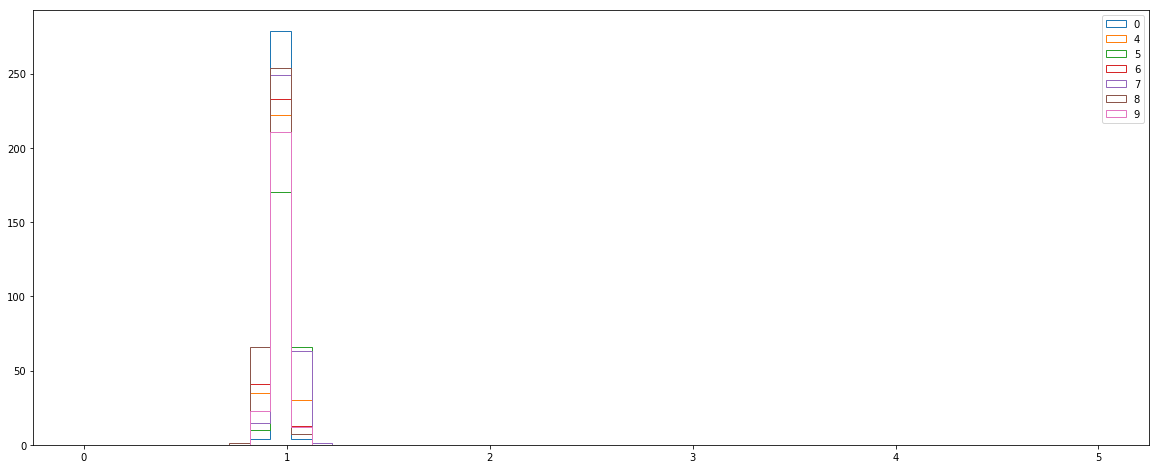

In [17]:
pl.clf()
fldstats = {}
for ii,fid in enumerate(np.unique(fieldid[obsid==oids[0]])):
    msk = (obsid==oids[0]) & (spwid == spwids[0]) & (fieldid==fid)
    if np.any(msk):
        dd = amp[0,0,msk]
        ok = (dd!=0) & (dd!=1)
        pl.hist(dd[ok], bins=np.linspace(0,5), histtype='step', label=f"{fid}")
        print(f"fid={fid}  mean={dd[ok].mean()}  median={np.median(dd[ok])}  rms={dd[ok].std()}")
        fldstats[fid] = [dd[ok].mean(), np.median(dd[ok]), dd[ok].std()]
pl.legend(loc='best')
pl.title("Amplitudes grouped by observation ID")
pl.xlabel("Amplitude")

In [18]:
fieldOKmask = np.isin(data['FIELD_ID'], okfields)
assert np.any(fieldOKmask)

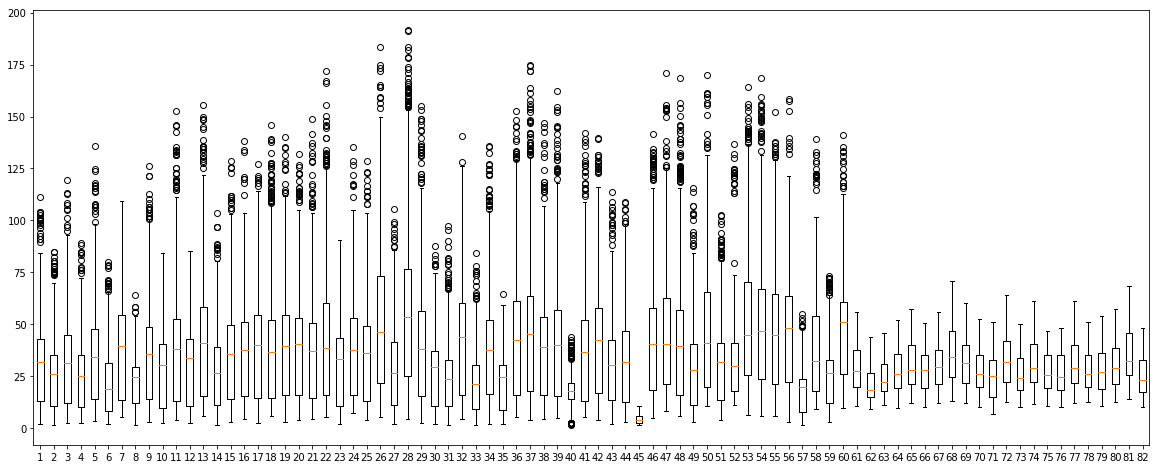

In [19]:
OK = data['SNR'] != 0
assert np.any(OK)

toplot = [data['SNR'][0,0, fieldOKmask & (OK[0,0,:]) & (data['ANTENNA1'] == ant)]
          for ant in np.unique(data['ANTENNA1'])]
toplot = [x for x in toplot if len(x) > 0]

_ = pl.boxplot(toplot)

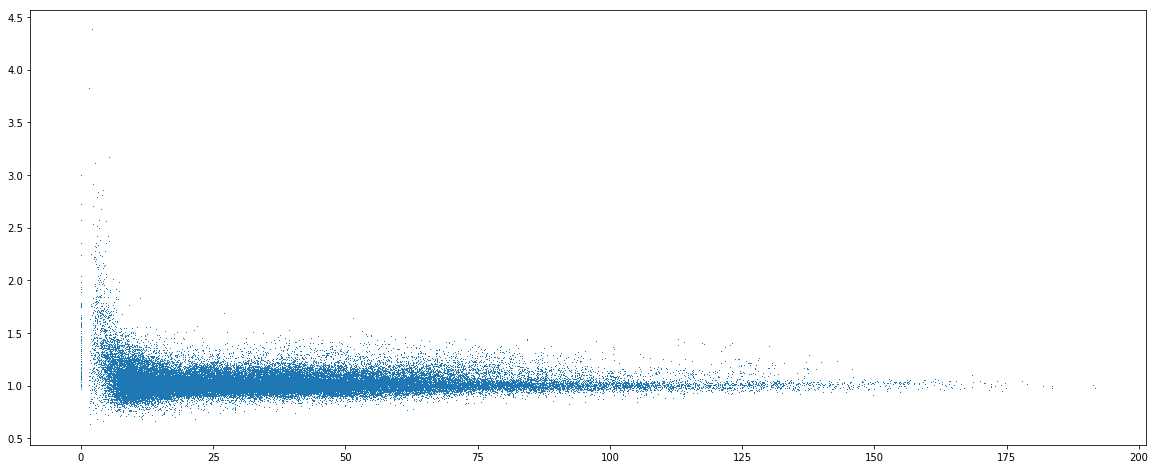

In [20]:
pl.plot(data['SNR'][0,0,:], data['AMP'][0,0,:], ',')

In [21]:
msmd.open(mstable)
antobs = {}
obsid = data['OBSERVATION_ID']
for oid in np.unique(obsid):
    antids = np.unique(data['ANTENNA1'][(obsid==oid) & (OK[0,0,:])])
    antnames = {k:v for k,v in zip(antids, msmd.antennanames(antids))}

    center = (np.mean([msmd.antennaoffset(k)['latitude offset']['value'] for k in antnames]),
              np.mean([msmd.antennaoffset(k)['longitude offset']['value'] for k in antnames]),)
    print(oid, center)
    
    antdist = {k:((msmd.antennaoffset(k)['latitude offset']['value']-center[0])**2 + (msmd.antennaoffset(k)['longitude offset']['value']-center[1])**2)**0.5
               for k in antnames}
    antloc = {k:(msmd.antennaoffset(k)['latitude offset']['value'], msmd.antennaoffset(k)['longitude offset']['value'])
               for k in antnames}

    antobs[oid] = {'antnames': antnames,
                   'antdist': antdist,
                   'antloc': antloc}
msmd.close()
antdist = {(ant,oid): antobs[oid]['antdist'][ant] for oid in antobs for ant in antobs[oid]['antnames']}
antnames = {(ant,oid): antobs[oid]['antnames'][ant] for oid in antobs for ant in antobs[oid]['antnames']}

3 (-706.0805971811877, 59.20789306974395)
4 (-694.2169343941254, 116.69211652013448)
7 (-770.3258456927032, 55.736620926651256)
8 (-724.0705997259637, 59.29486709345053)
9 (-758.1024676438351, 53.72945815419189)
10 (-758.1024676438351, 53.72945815419189)
11 (-697.1749017682382, 29.320079114628612)


In [22]:
antstats = {}
for oid in np.unique(data['OBSERVATION_ID']):
    for antid in np.unique(data['ANTENNA1']):
        msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & fieldOKmask & (data['OBSERVATION_ID'] == oid)
        if np.any(msk) and (antid, oid) in antnames:
            dat = data['SNR'][1,0, msk]
            ang = data['ANGLE'][1,0, msk]
            amp = data['AMP'][1,0, msk]
            print(f"antenna={antnames[(antid,oid)]} oid={oid} dist={antdist[(antid,oid)]:6.1f} "
                  f"mean={dat.mean():10.2f} median={np.median(dat):10.2f} "
                  f"std={dat.std():10.2f} amp mean={amp.mean():10.2f} "
                  f"amp std={amp.std():10.2f} angle_rms={ang.std()*180/np.pi:10.2f}")
            antstats[(antid,oid)] = {'mean':dat.mean(),
                               'median':np.median(dat),
                               'std': dat.std(),
                               'angle_rms': ang.std(),
                               'amp_mean': amp.mean(),
                               'amp_std': amp.std(),
                              }

antenna=DA41 oid=3 dist= 845.5 mean=     42.31 median=     45.27 std=     25.80 amp mean=      0.97 amp std=      0.07 angle_rms=      1.79
antenna=DA42 oid=3 dist=1295.3 mean=     32.70 median=     34.86 std=     19.40 amp mean=      0.99 amp std=      0.10 angle_rms=      1.80
antenna=DA43 oid=3 dist= 938.9 mean=     45.82 median=     45.05 std=     28.64 amp mean=      0.98 amp std=      0.07 angle_rms=      1.88
antenna=DA44 oid=3 dist=1263.0 mean=     35.76 median=     37.62 std=     22.20 amp mean=      0.98 amp std=      0.08 angle_rms=      1.95
antenna=DA45 oid=3 dist= 524.8 mean=     50.35 median=     50.37 std=     31.41 amp mean=      0.96 amp std=      0.05 angle_rms=      1.75
antenna=DA46 oid=3 dist=1688.1 mean=     32.28 median=     33.17 std=     19.58 amp mean=      1.01 amp std=      0.10 angle_rms=      1.61
antenna=DA47 oid=3 dist= 627.6 mean=     42.81 median=     42.10 std=     26.29 amp mean=      0.97 amp std=      0.06 angle_rms=      1.55
antenna=DA50 oid=3 d

In [23]:
uoids = np.unique(data['OBSERVATION_ID'])

In [24]:
[len([antstats[(ant,oid)]['mean'] for ant,_ in antstats  if (ant,oid) in antstats]) for oid in uoids]

[215, 218, 228, 233, 236, 236, 152]

In [25]:
[len([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats]) for oid in uoids]

[215, 218, 228, 233, 236, 236, 152]

Text(0, 0.5, 'Gaincal SNR')

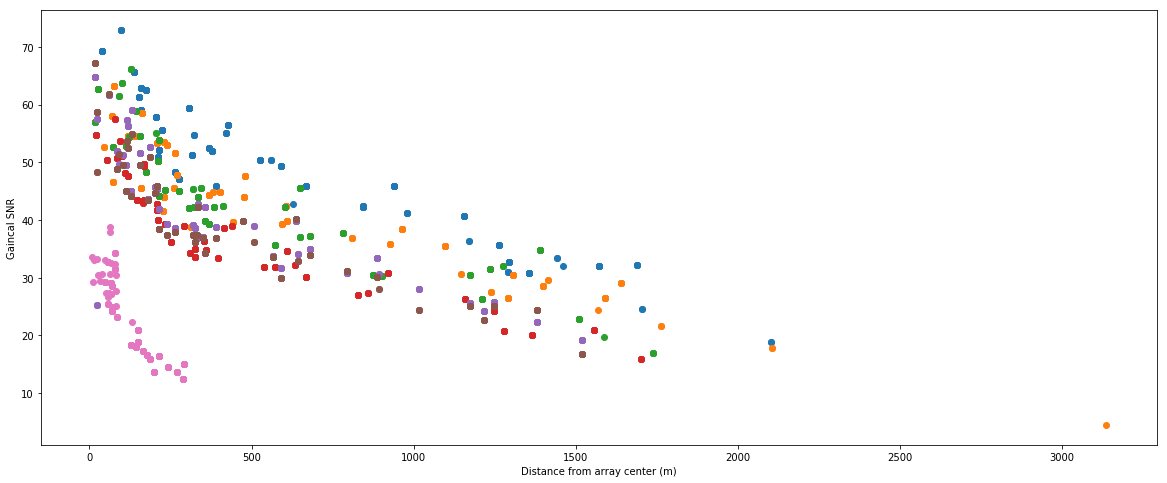

In [26]:
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Gaincal SNR")    

Text(0, 0.5, 'Mean amplitude correction')

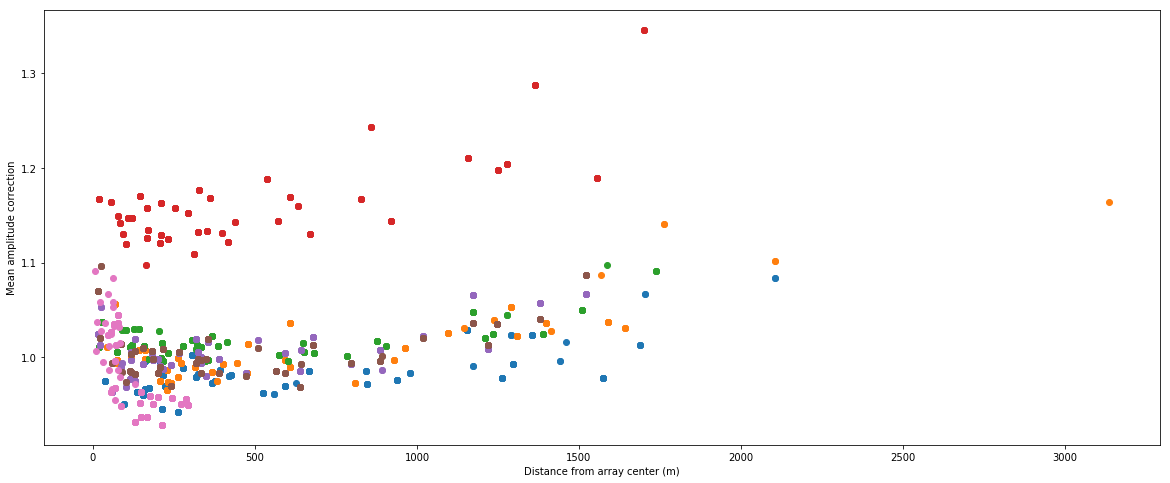

In [27]:
uoids = np.unique(data['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['amp_mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Mean amplitude correction")

In [28]:
caltable = 'W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_amp6_inf.cal'
with CasaTable(caltable) as tb:
    amp = np.abs(tb.getcol('CPARAM'))
    angle = np.angle(tb.getcol('CPARAM'))
    data6 = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
data6['ANGLE'] = angle
data6['AMP'] = amp

In [29]:
data=data6
fieldOKmask = np.isin(data['FIELD_ID'], okfields)
OK = data['SNR'] != 0
antstats = {}
for oid in np.unique(data['OBSERVATION_ID']):
    for antid in np.unique(data['ANTENNA1']):
        msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & fieldOKmask & (data['OBSERVATION_ID'] == oid)
        if np.any(msk) and (antid, oid) in antnames:
            dat = data['SNR'][1,0, msk]
            ang = data['ANGLE'][1,0, msk]
            amp = data['AMP'][1,0, msk]
            print(f"antenna={antnames[(antid,oid)]} oid={oid} dist={antdist[(antid,oid)]:6.1f} "
                  f"mean={dat.mean():10.2f} median={np.median(dat):10.2f} "
                  f"std={dat.std():10.2f} amp mean={amp.mean():10.2f} "
                  f"amp std={amp.std():10.2f} angle_rms={ang.std()*180/np.pi:10.2f}")
            antstats[(antid,oid)] = {'mean':dat.mean(),
                               'median':np.median(dat),
                               'std': dat.std(),
                               'angle_rms': ang.std(),
                               'amp_mean': amp.mean(),
                               'amp_std': amp.std(),
                              }

antenna=DA41 oid=3 dist= 845.5 mean=     42.41 median=     45.49 std=     25.90 amp mean=      1.01 amp std=      0.03 angle_rms=      1.79
antenna=DA42 oid=3 dist=1295.3 mean=     32.72 median=     34.86 std=     19.57 amp mean=      1.01 amp std=      0.05 angle_rms=      1.73
antenna=DA43 oid=3 dist= 938.9 mean=     45.92 median=     45.42 std=     28.72 amp mean=      1.01 amp std=      0.03 angle_rms=      1.77
antenna=DA44 oid=3 dist=1263.0 mean=     35.83 median=     37.41 std=     22.27 amp mean=      1.00 amp std=      0.04 angle_rms=      1.80
antenna=DA45 oid=3 dist= 524.8 mean=     50.46 median=     50.70 std=     31.47 amp mean=      1.00 amp std=      0.03 angle_rms=      1.77
antenna=DA46 oid=3 dist=1688.1 mean=     32.50 median=     33.61 std=     19.64 amp mean=      1.01 amp std=      0.06 angle_rms=      1.76
antenna=DA47 oid=3 dist= 627.6 mean=     42.89 median=     42.22 std=     26.39 amp mean=      1.01 amp std=      0.04 angle_rms=      1.73
antenna=DA50 oid=3 d

Text(0, 0.5, 'Mean amplitude correction')

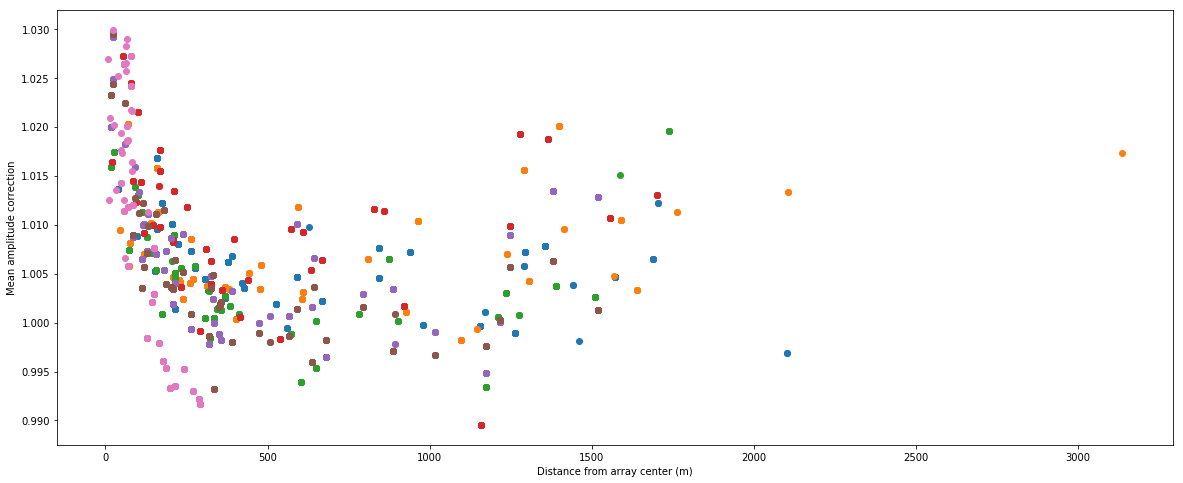

In [30]:
uoids = np.unique(data6['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['amp_mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Mean amplitude correction")

In [ ]:
print("TEST")